In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

np.random.seed(42)  # 保证复现实验

# 生成日期（2023年1月1日-2024年5月15日，连续500天）
start_date = datetime(2023, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(500)]

# 生成各项空气质量和气象指标数据（仿真）
data = {
    "date": [d.strftime("%Y-%m-%d") for d in dates],
    "PM2.5": np.clip(np.random.normal(70, 25, 500), 20, 180).round(1),
    "PM10": np.clip(np.random.normal(110, 30, 500), 40, 250).round(1),
    "NO2": np.clip(np.random.normal(40, 12, 500), 10, 85).round(1),
    "SO2": np.clip(np.random.normal(12, 4, 500), 4, 38).round(1),
    "CO": np.clip(np.random.normal(0.8, 0.25, 500), 0.3, 2.5).round(2),
    "O3": np.clip(np.random.normal(65, 20, 500), 15, 160).round(1),
    "temp": np.clip(np.random.normal(15, 10, 500), -10, 35).round(1),
    "humidity": np.clip(np.random.normal(45, 18, 500), 10, 95).round(1),
    "windspeed": np.clip(np.random.normal(2.8, 0.8, 500), 0.5, 6).round(2)
}

df = pd.DataFrame(data)

# 生成PM2.5滞后特征
for i in range(1, 4):
    df[f"PM2.5_lag{i}"] = df["PM2.5"].shift(i)
df = df.dropna().reset_index(drop=True)

df.to_csv("air_quality_simulated.csv", index=False, encoding="utf-8")
print("已生成500条仿真太原空气质量数据，文件名为 air_quality_simulated.csv")


已生成500条仿真太原空气质量数据，文件名为 air_quality_simulated.csv


In [4]:
import pandas as pd

# 1. 数据加载
data = pd.read_csv('air_quality_simulated.csv')  # 请确保数据文件已准备好

# 构造统计特征：PM2.5三日均值和最大值
data['PM2.5_mean3'] = data['PM2.5'].rolling(window=3).mean().shift(1)
data['PM2.5_max3'] = data['PM2.5'].rolling(window=3).max().shift(1)
data = data.dropna().reset_index(drop=True)

#  特征工程：选取特征与目标变量
features = ['PM10', 'NO2', 'SO2', 'CO', 'O3', 'temp', 'humidity', 'windspeed', 
            'PM2.5_lag1', 'PM2.5_lag2', 'PM2.5_lag3']
X = data[features]
y = data['PM2.5']

# 可选：预览数据
print(X.head())
print(y.head())


    PM10   NO2   SO2    CO     O3  temp  humidity  windspeed  PM2.5_lag1  \
0   92.2  50.7  14.8  0.80  124.0  19.9      50.8       0.64        64.1   
1   84.1  47.6  15.8  0.60   89.9  -0.5      43.9       2.30       109.5   
2  111.5  52.6  12.4  0.96   38.0  25.8      54.0       2.41        89.2   
3   85.1  33.6  17.9  1.03   38.6  10.3      35.4       3.31        58.3   
4  118.1  55.8   7.4  0.40   74.6  14.1      67.0       2.82        83.6   

   PM2.5_lag2  PM2.5_lag3  
0        64.1       108.1  
1        64.1        64.1  
2       109.5        64.1  
3        89.2       109.5  
4        58.3        89.2  
0    109.5
1     89.2
2     58.3
3     83.6
4     58.4
Name: PM2.5, dtype: float64


In [5]:
from sklearn.model_selection import train_test_split

# 训练集和测试集划分
# 按 80%:20% 比例划分训练集与测试集，确保实验可复现（random_state=42）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 可选：输出划分后数据集的形状
print("训练集样本数:", X_train.shape[0])
print("测试集样本数:", X_test.shape[0])


训练集样本数: 395
测试集样本数: 99


In [6]:
# Z-score标准化 
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
from sklearn.linear_model import LinearRegression

# 线性回归模型训练与预测
lr = LinearRegression()
lr.fit(X_train, y_train)           # 在训练集上拟合模型
y_pred_lr = lr.predict(X_test)     # 在测试集上做出预测

# 可选：输出前10个预测值与真实值对比
print("线性回归模型部分预测结果：")
for i in range(10):
    print(f"真实值: {y_test.values[i]:.2f}  预测值: {y_pred_lr[i]:.2f}")


线性回归模型部分预测结果：
真实值: 70.90  预测值: 67.63
真实值: 20.30  预测值: 70.00
真实值: 87.00  预测值: 71.72
真实值: 48.60  预测值: 69.30
真实值: 80.30  预测值: 77.18
真实值: 84.30  预测值: 73.62
真实值: 89.70  预测值: 66.06
真实值: 65.40  预测值: 69.34
真实值: 99.00  预测值: 70.71
真实值: 55.90  预测值: 70.66


In [8]:
from sklearn.ensemble import RandomForestRegressor

# 随机森林模型训练与预测
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)              # 在训练集上拟合模型
y_pred_rf = rf.predict(X_test)        # 在测试集上做出预测

# 可选：输出前10个预测值与真实值对比
print("随机森林模型部分预测结果：")
for i in range(10):
    print(f"真实值: {y_test.values[i]:.2f}  预测值: {y_pred_rf[i]:.2f}")


随机森林模型部分预测结果：
真实值: 70.90  预测值: 74.78
真实值: 20.30  预测值: 75.85
真实值: 87.00  预测值: 78.95
真实值: 48.60  预测值: 69.28
真实值: 80.30  预测值: 80.05
真实值: 84.30  预测值: 73.37
真实值: 89.70  预测值: 59.76
真实值: 65.40  预测值: 69.28
真实值: 99.00  预测值: 80.17
真实值: 55.90  预测值: 69.62


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 线性回归模型性能评估
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("=== 线性回归模型评价指标 ===")
print(f"MAE: {mae_lr:.2f}")
print(f"MSE: {mse_lr:.2f}")
print(f"R2 : {r2_lr:.3f}")

# 随机森林模型性能评估
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("=== 随机森林模型评价指标 ===")
print(f"MAE: {mae_rf:.2f}")
print(f"MSE: {mse_rf:.2f}")
print(f"R2 : {r2_rf:.3f}")


=== 线性回归模型评价指标 ===
MAE: 18.86
MSE: 585.50
R2 : -0.044
=== 随机森林模型评价指标 ===
MAE: 19.26
MSE: 604.61
R2 : -0.078


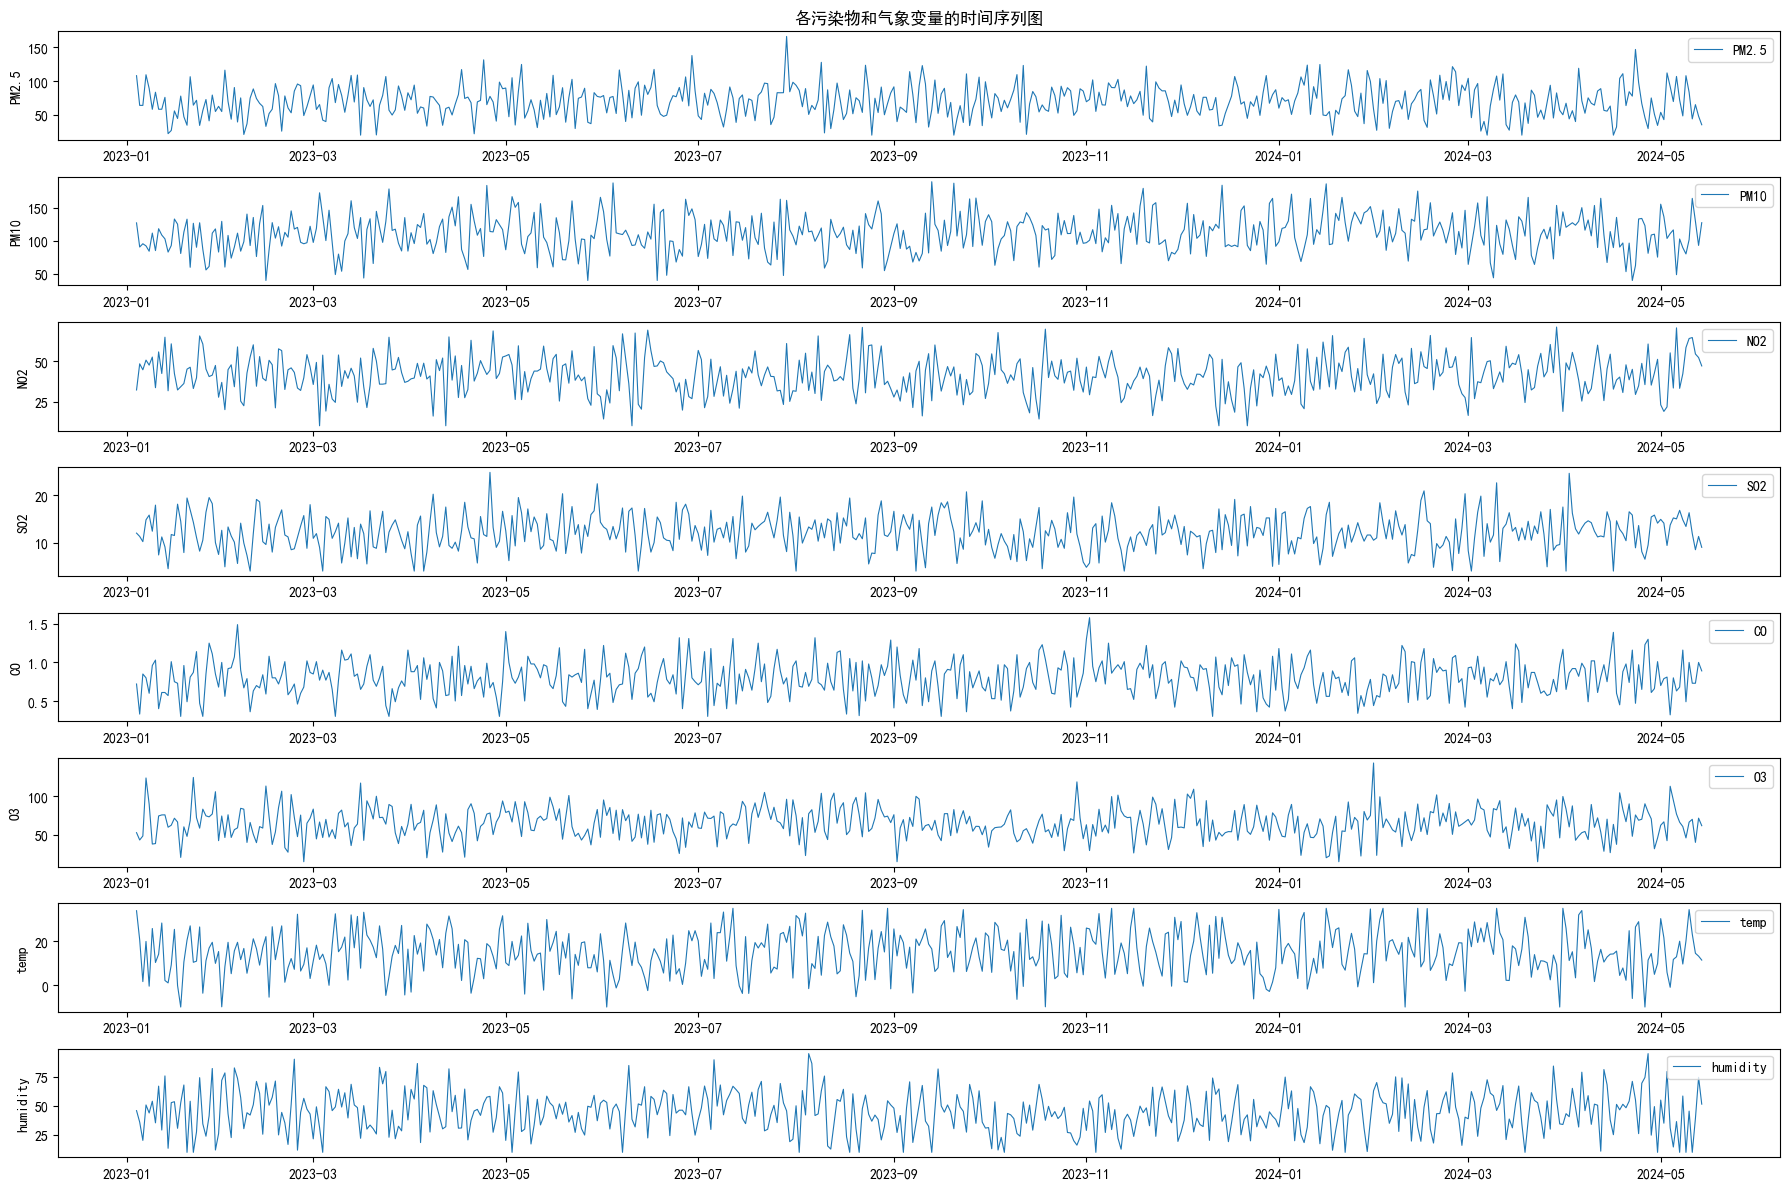

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 数据读取
# 假设数据文件名为 air_quality_simulated.csv，日期列为 date
# 主要字段示例：['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'temp', 'humidity']
df = pd.read_csv('air_quality_simulated.csv', parse_dates=['date'])

# 按时间排序，设置日期为索引
df = df.sort_values('date')
df = df.set_index('date')

# 选择分析变量
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
meteo = ['temp', 'humidity']  # 气温和相对湿度
features = pollutants + meteo

# 绘制时间序列图
plt.figure(figsize=(18, 12))
for i, col in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    plt.plot(df.index, df[col], label=col, linewidth=0.8)
    plt.ylabel(col)
    plt.legend(loc='upper right')
    if i == 0:
        plt.title('各污染物和气象变量的时间序列图')
plt.tight_layout()
plt.show()

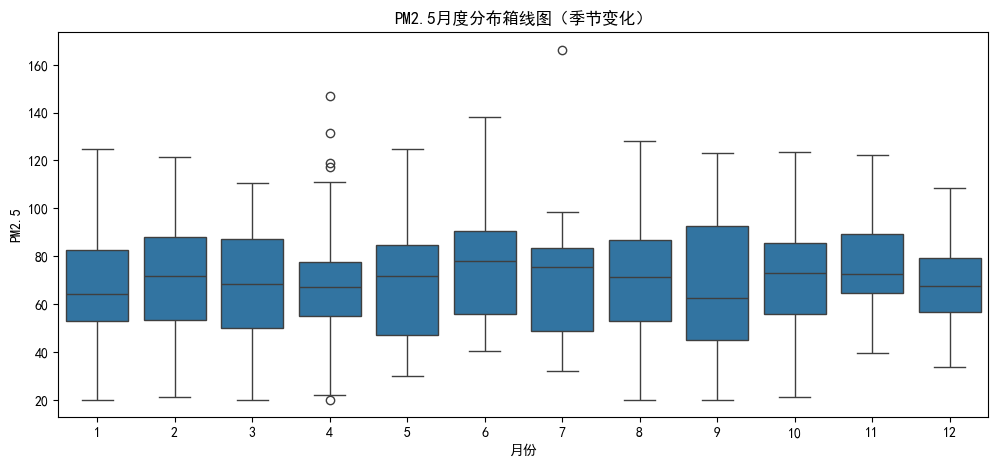

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#  季节与周期性分析（以PM2.5为例，绘制月分布箱线图）
df['month'] = df.index.month
plt.figure(figsize=(12, 5))
sns.boxplot(x='month', y='PM2.5', data=df)
plt.title('PM2.5月度分布箱线图（季节变化）')
plt.xlabel('月份')
plt.ylabel('PM2.5')
plt.show()

In [20]:
# 极端污染事件识别（以PM2.5为例，99%分位数为阈值）
extreme_pm25 = df[df['PM2.5'] > df['PM2.5'].quantile(0.99)]
print("极端PM2.5污染事件（99%分位以上）:")
print(extreme_pm25[['PM2.5']])

极端PM2.5污染事件（99%分位以上）:
            PM2.5
date             
2023-04-24  131.6
2023-06-29  138.0
2023-07-29  166.3
2023-08-09  127.9
2024-04-23  147.0


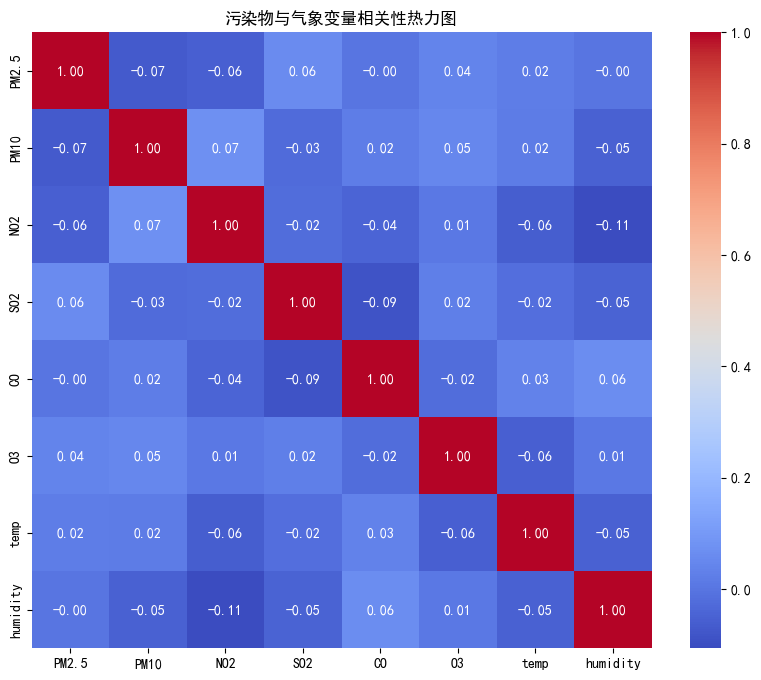

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 7热力图展示特征间相关性
corr = df[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('污染物与气象变量相关性热力图')
plt.show()

In [22]:
#  输出PM2.5与主要变量的相关性
print("PM2.5与其它变量的相关系数：")
print(corr['PM2.5'].sort_values(ascending=False))

PM2.5与其它变量的相关系数：
PM2.5       1.000000
SO2         0.059931
O3          0.036321
temp        0.022962
CO         -0.001988
humidity   -0.002388
NO2        -0.058429
PM10       -0.069935
Name: PM2.5, dtype: float64


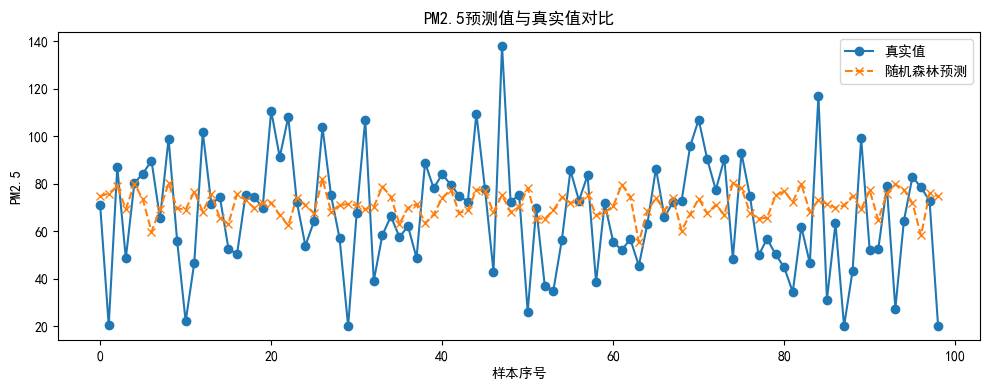

In [23]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

import matplotlib.pyplot as plt

# 预测结果与真实值对比（以随机森林模型为例）
plt.figure(figsize=(10, 4))
plt.plot(y_test.values[:100], label='真实值', marker='o', linestyle='-')
plt.plot(y_pred_rf[:100], label='随机森林预测', marker='x', linestyle='--')
plt.xlabel('样本序号')
plt.ylabel('PM2.5')
plt.title('PM2.5预测值与真实值对比')
plt.legend()
plt.tight_layout()
plt.savefig('Fig7-2_pred_vs_true.png')  # 保存图片，便于插入论文
plt.show()


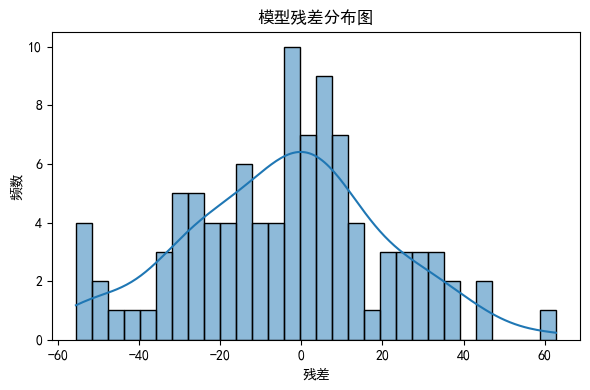

In [29]:
import seaborn as sns

# 残差分布图（以随机森林模型为例）
residuals = y_test - y_pred_rf
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('残差')
plt.ylabel('频数')
plt.title('模型残差分布图')
plt.tight_layout()
plt.savefig('Fig7-3_residuals.png')  # 保存图片，便于插入论文
plt.show()


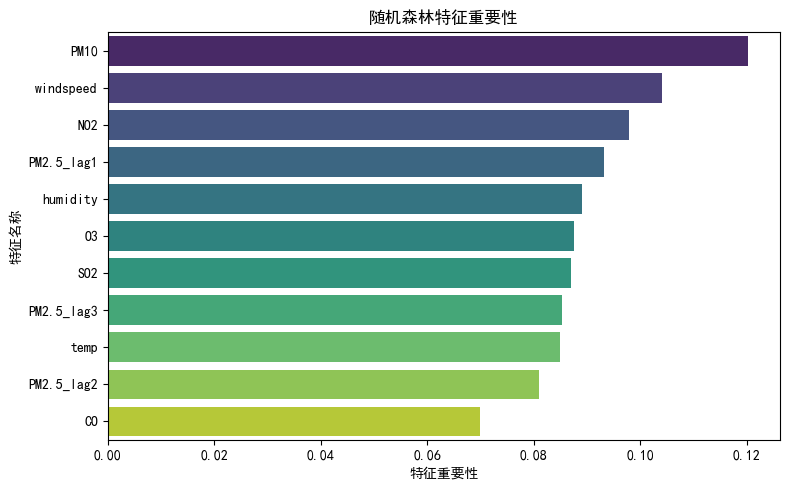

In [32]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns if hasattr(X_train, "columns") else np.arange(len(importances))

plt.figure(figsize=(8, 5))
sns.barplot(
    x=importances[indices],
    y=np.array(feature_names)[indices],
    hue=np.array(feature_names)[indices],  # 关键改动
    palette='viridis',
    legend=False
)
plt.xlabel('特征重要性')
plt.ylabel('特征名称')
plt.title('随机森林特征重要性')
plt.tight_layout()
plt.savefig('Fig_feat_importance.png')
plt.show()